<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### 1 - Datos
El objecto es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [1]:
#!python3 -m pip install 'tensorflow[and-cuda]'
#!pip install tensorflow==2.12
#!pip install keras_preprocessing
#!pip install keras

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-12-09 23:39:16.432549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/carlaespinola/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[]


In [3]:
import re

import numpy as np
import pandas as pd

from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping

In [4]:
# Descargar la carpeta de dataset

import os
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [87]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 50000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    # el tabulador señaliza la separación entre las oraciones 
    # en ambos idiomas
    if '\t' not in line: 
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 50000


In [88]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2 - Preprocesamiento

In [89]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 10000
# Vamos a necesitar un tokenizador para cada idioma

In [90]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> el número máximo de palabras a conservar, en función de la frecuencia de las palabras.
# - Solo se conservarán las num_words-1 palabras más comunes.
from keras.preprocessing.text import Tokenizer

# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 9994
Sentencia de entrada más larga: 47


In [91]:
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 18056
Sentencia de salida más larga: 48


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

In [92]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 16
max_out_len = 18

A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [93]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 50000
encoder_input_sequences shape: (50000, 16)
decoder_input_sequences shape: (50000, 18)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [94]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(50000, 18, 10000)

### 3 - Preparar los embeddings

In [95]:
#import sys
#!{sys.executable} -m pip install gdown


In [96]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [97]:
# En caso de que gdown de algún error de permisos intentar descargar los
# embeddings con curl:

#!curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [98]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [99]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [100]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

if embedding_matrix.shape[0] < (np.max(encoder_input_sequences) + 1):
    diff = (np.max(encoder_input_sequences) + 1) - embedding_matrix.shape[0]
    embedding_matrix = np.vstack([embedding_matrix,
                                  np.zeros((diff, embedding_matrix.shape[1]))])
    
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 131


In [101]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(9995, 50)

### 4 - Entrenar el modelo

#### Construir modelos

In [102]:
max_input_len

16

In [103]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

def build_traductor_model(n_units=128, encoder_input_sequences_m=None, embedding_matrix_m=None):
    """Construye un modelo de lenguaje a nivel de caracteres."""

    # define training encoder
    encoder_inputs = Input(shape=(max_input_len))

    #encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

    encoder_input_sequences_m = np.clip(
        encoder_input_sequences_m,
        0,
        embedding_matrix_m.shape[0] - 1
    )

    encoder_embedding_layer = Embedding(
            input_dim=np.max(encoder_input_sequences_m) + 1,  # definido en el Tokenizador
            output_dim=embed_dim,  # dimensión de los embeddings utilizados
            input_length=max_input_len, # tamaño máximo de la secuencia de entrada
            weights=[embedding_matrix_m],  # matrix de embeddings
            trainable=False)      # marcar como layer no entrenable

    encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
    encoder_states = [state_h, state_c]

    # define training decoder
    decoder_inputs = Input(shape=(max_out_len))
    decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
    decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

    # Dense
    decoder_dense = Dense(num_words_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
    model_env = {
        'model': model,
        'encoder_inputs': encoder_inputs,
        'encoder_states': encoder_states,
        'decoder_embedding_layer': decoder_embedding_layer,
        'decoder_lstm': decoder_lstm,
        'decoder_dense': decoder_dense,
        'encoder_input_sequences': encoder_input_sequences_m
    }
    return model_env

In [104]:
n_units_list = [64, 128, 256]
#n_units_list = [128, 256]
models = {f'n_units_{n_units}': None for n_units in n_units_list}

for n_units in n_units_list:
    model_env = build_traductor_model(n_units=n_units, encoder_input_sequences_m=encoder_input_sequences, embedding_matrix_m=embedding_matrix)
    models[f'n_units_{n_units}'] = model_env
    del model_env

#### Summary

In [105]:
m_64 = models['n_units_64']
m_128 = models['n_units_128']
m_256 = models['n_units_256']

In [106]:
print("Resumen del modelo con 64 unidades LSTM:")
m_64['model'].summary()

Resumen del modelo con 64 unidades LSTM:
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 16)]                 0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 18)]                 0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 16, 50)               499750    ['input_15[0][0]']            
                                                                                                  
 embedding_9 (Embedding)     (None, 18, 64)               640000    ['input_16[0][0]']            
                                                   

In [107]:
print(f"Modelo con 128 unidades:")
m_128['model'].summary()

Modelo con 128 unidades:
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 16)]                 0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 18)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 16, 50)               499750    ['input_17[0][0]']            
                                                                                                  
 embedding_11 (Embedding)    (None, 18, 128)              1280000   ['input_18[0][0]']            
                                                                   

In [108]:
print(f"Modelo con 256 unidades:")
m_256['model'].summary()

Modelo con 256 unidades:
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 16)]                 0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 18)]                 0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 16, 50)               499750    ['input_19[0][0]']            
                                                                                                  
 embedding_13 (Embedding)    (None, 18, 256)              2560000   ['input_20[0][0]']            
                                                                  

#### Visualizar arquitectura completa

In [28]:
#!brew install graphviz
#!pip install pydot graphviz
#import sys
#!{sys.executable} -m pip install pydot graphviz

In [ ]:
# Modelo completo (encoder+decoder) para poder entrenar
print("Arquitectura del modelo con 128 unidades:")
plot_model(m_128['model'], to_file='model_plot_128.png', show_shapes=True, show_layer_names=True)

Arquitectura del modelo con 64 unidades:


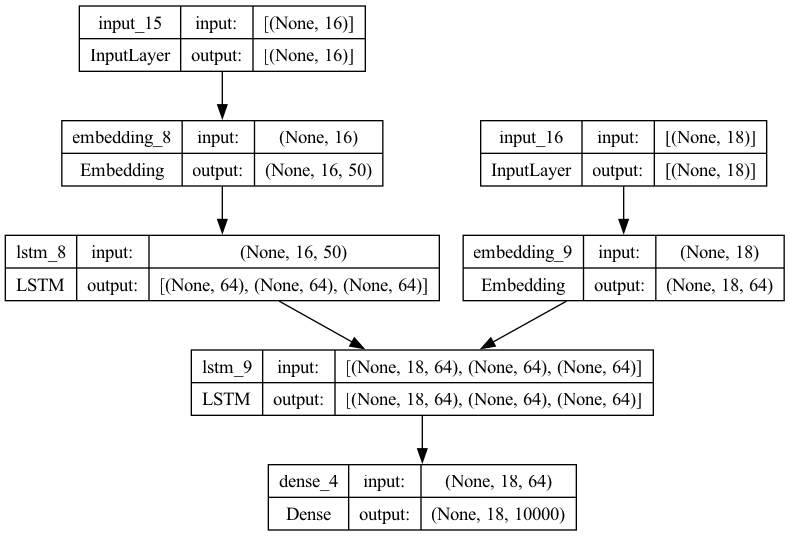

In [109]:
# Modelo completo (encoder+decoder) para poder entrenar
print("Arquitectura del modelo con 64 unidades:")
plot_model(m_64['model'], to_file='model_plot_64.png', show_shapes=True, show_layer_names=True)

Arquitectura del modelo con 256 unidades:


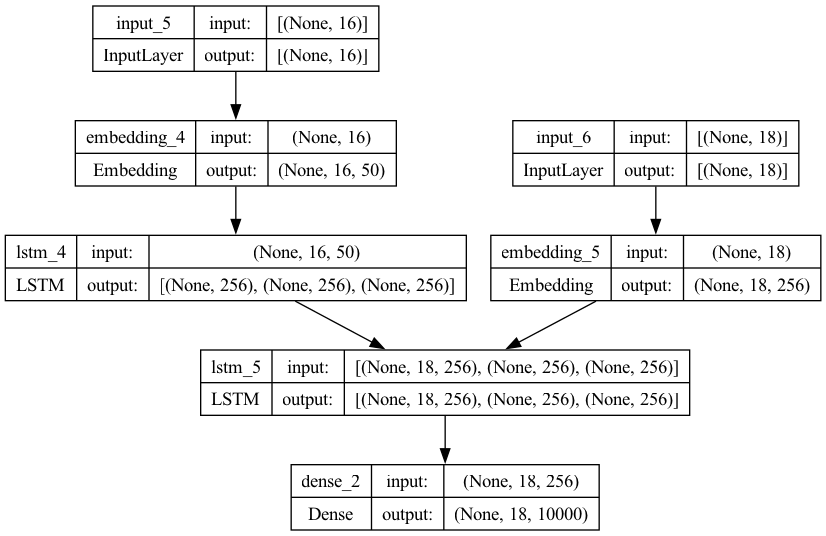

In [30]:
print("Arquitectura del modelo con 256 unidades:")
plot_model(m_256['model'], to_file='model_plot_256.png', show_shapes=True, show_layer_names=True)

Arquitectura del modelo con 256 unidades:


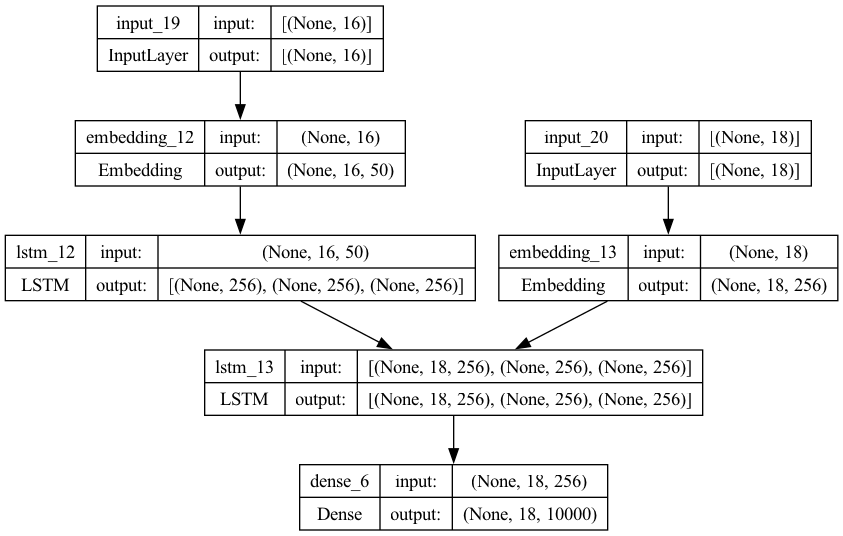

In [110]:
# Modelo completo (encoder+decoder) para poder entrenar
print("Arquitectura del modelo con 256 unidades:")
plot_model(m_256['model'], to_file='model_plot_256.png', show_shapes=True, show_layer_names=True)

#### Visualizar encoder

Arquitectura del encoder 64:


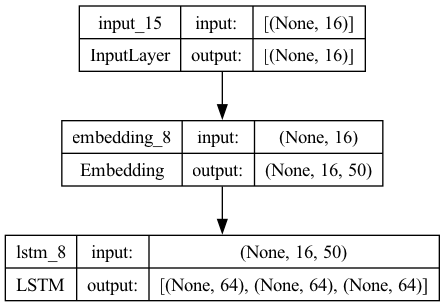

In [111]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(m_64['encoder_inputs'], m_64['encoder_states'])
print("Arquitectura del encoder 64:")
plot_model(encoder_model, to_file='encoder_plot_64.png', show_shapes=True, show_layer_names=True)

Arquitectura del encoder 128:


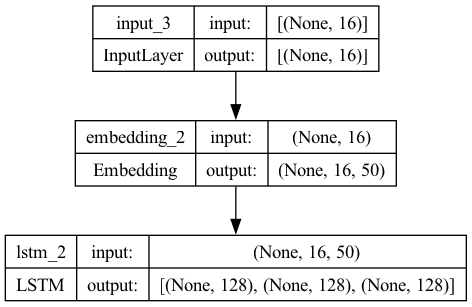

In [ ]:
# define inference encoder
encoder_model = Model(m_128['encoder_inputs'], m_128['encoder_states'])
print("Arquitectura del encoder 128:")
plot_model(encoder_model, to_file='encoder_plot_128.png', show_shapes=True, show_layer_names=True)

Arquitectura del encoder 256:


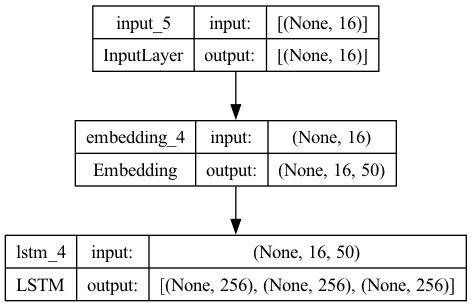

In [32]:
encoder_model = Model(m_256['encoder_inputs'], m_256['encoder_states'])
print("Arquitectura del encoder 256:")
plot_model(encoder_model, to_file='encoder_plot_256.png', show_shapes=True, show_layer_names=True)

#### Visualizar decoder

Arquitectura del decoder 64:


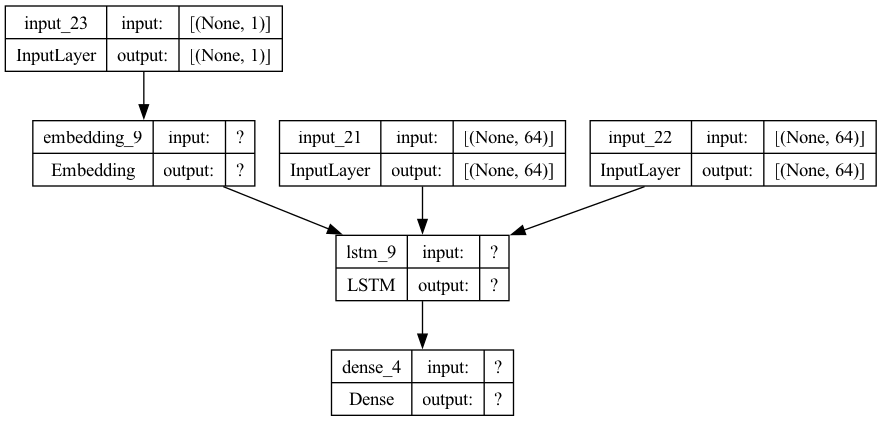

In [112]:
# Modelo solo decoder (para realizar inferencia)
n_units = 64
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = m_64['decoder_embedding_layer'](decoder_inputs_single)

decoder_outputs, state_h, state_c = m_64['decoder_lstm'](decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = m_64['decoder_dense'](decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

print("Arquitectura del decoder 64:")
plot_model(decoder_model, to_file='decoder_plot_64.png', show_shapes=True, show_layer_names=True)

Arquitectura del decoder 128:


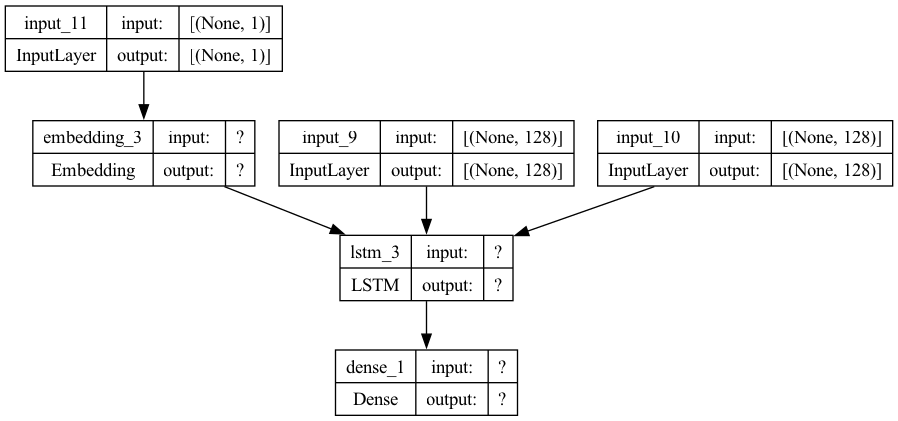

In [33]:
# Modelo solo decoder (para realizar inferencia)
n_units = 128
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = m_128['decoder_embedding_layer'](decoder_inputs_single)

decoder_outputs, state_h, state_c = m_128['decoder_lstm'](decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = m_128['decoder_dense'](decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

print("Arquitectura del decoder 128:")
plot_model(decoder_model, to_file='decoder_plot_128.png', show_shapes=True, show_layer_names=True)

Arquitectura del decoder 256:


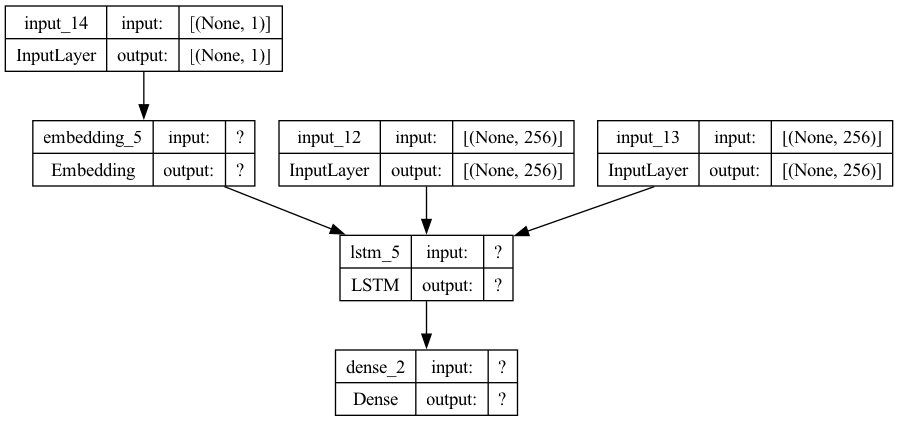

In [34]:
n_units = 256
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]  

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = m_256['decoder_embedding_layer'](decoder_inputs_single)   
decoder_outputs, state_h, state_c = m_256['decoder_lstm'](decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = m_256['decoder_dense'](decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

print("Arquitectura del decoder 256:")
plot_model(decoder_model, to_file='decoder_plot_256.png', show_shapes=True, show_layer_names=True)

#### Entrenar modelos

In [113]:
# EarlyStopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
hist = m_64['model'].fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=15,
    validation_split=0.2,
    callbacks=[early_stopping]
)

models['n_units_64']['hist'] = hist

Epoch 1/15
1250/1250 [==============================] - 172s 135ms/step - loss: 2.4954 - accuracy: 0.6670 - val_loss: 2.0630 - val_accuracy: 0.6925
Epoch 2/15
1250/1250 [==============================] - 140s 112ms/step - loss: 1.9440 - accuracy: 0.7030 - val_loss: 1.8703 - val_accuracy: 0.7109
Epoch 3/15
 823/1250 [==================>...........] - ETA: 47s - loss: 1.7917 - accuracy: 0.7169

In [ ]:
hist = m_128['model'].fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=15, 
    validation_split=0.2,
    callbacks=[early_stopping]
)

models['n_units_128']['hist'] = hist

Epoch 1/15
500/500 [==============================] - 95s 179ms/step - loss: 2.7528 - accuracy: 0.6468 - val_loss: 2.0942 - val_accuracy: 0.6943
Epoch 2/15
500/500 [==============================] - 78s 157ms/step - loss: 2.1566 - accuracy: 0.6859 - val_loss: 1.9557 - val_accuracy: 0.7044
Epoch 3/15
500/500 [==============================] - 79s 157ms/step - loss: 1.9824 - accuracy: 0.7002 - val_loss: 1.8398 - val_accuracy: 0.7154
Epoch 4/15
500/500 [==============================] - 76s 153ms/step - loss: 1.8403 - accuracy: 0.7126 - val_loss: 1.7601 - val_accuracy: 0.7235
Epoch 5/15
500/500 [==============================] - 78s 156ms/step - loss: 1.7263 - accuracy: 0.7229 - val_loss: 1.7084 - val_accuracy: 0.7279
Epoch 6/15
500/500 [==============================] - 77s 155ms/step - loss: 1.6300 - accuracy: 0.7305 - val_loss: 1.6744 - val_accuracy: 0.7298
Epoch 7/15
500/500 [==============================] - 77s 155ms/step - loss: 1.5463 - accuracy: 0.7369 - val_loss: 1.6467 - val_ac

In [ ]:
hist = m_256['model'].fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=15, 
    validation_split=0.2,
    callbacks=[early_stopping]
)

models['n_units_256']['hist'] = hist

Epoch 1/15
500/500 [==============================] - 125s 242ms/step - loss: 2.5435 - accuracy: 0.6611 - val_loss: 2.0434 - val_accuracy: 0.6958
Epoch 2/15
500/500 [==============================] - 115s 230ms/step - loss: 2.0631 - accuracy: 0.6929 - val_loss: 1.8589 - val_accuracy: 0.7131
Epoch 3/15
500/500 [==============================] - 112s 225ms/step - loss: 1.8494 - accuracy: 0.7112 - val_loss: 1.7416 - val_accuracy: 0.7230
Epoch 4/15
500/500 [==============================] - 111s 222ms/step - loss: 1.6792 - accuracy: 0.7258 - val_loss: 1.6638 - val_accuracy: 0.7308
Epoch 5/15
500/500 [==============================] - 112s 224ms/step - loss: 1.5399 - accuracy: 0.7370 - val_loss: 1.6136 - val_accuracy: 0.7369
Epoch 6/15
500/500 [==============================] - 113s 226ms/step - loss: 1.4223 - accuracy: 0.7454 - val_loss: 1.5829 - val_accuracy: 0.7395
Epoch 7/15
500/500 [==============================] - 110s 220ms/step - loss: 1.3170 - accuracy: 0.7536 - val_loss: 1.5651 -

#### Comprar modelos

Resultados del modelo con 64 unidades:


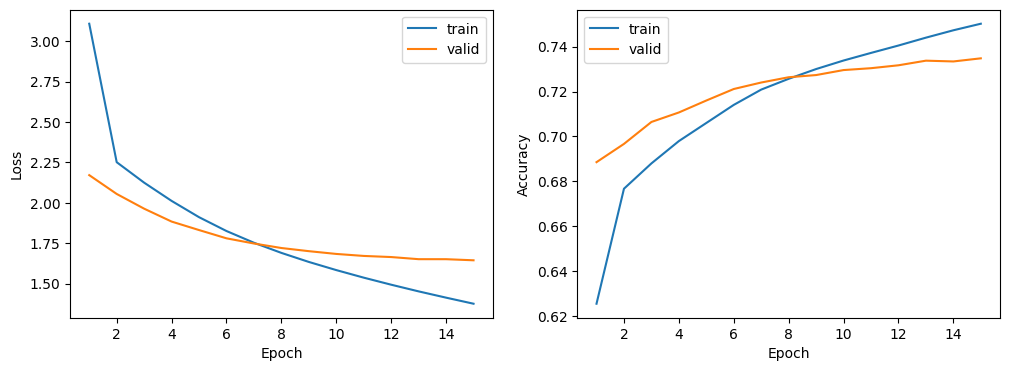

Resultados del modelo con 128 unidades:


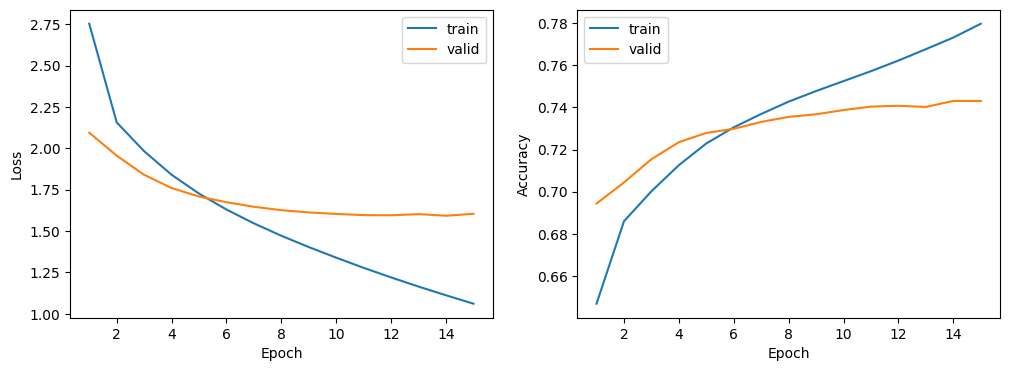

Resultados del modelo con 256 unidades:


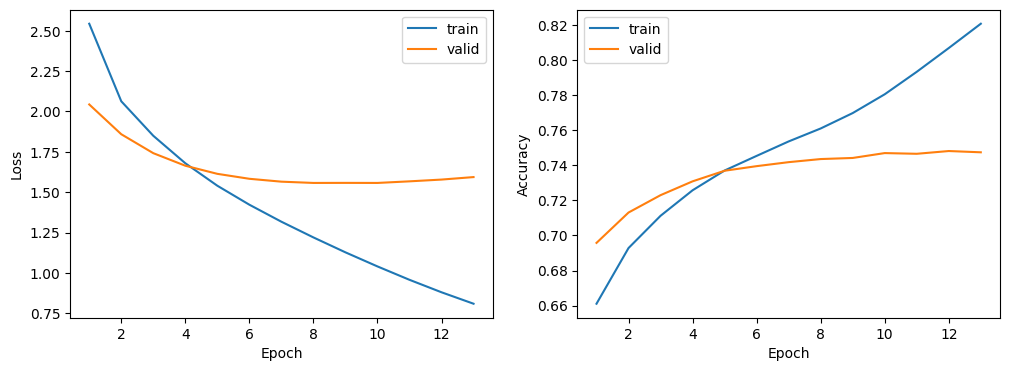

Resultados del modelo con 512 unidades:


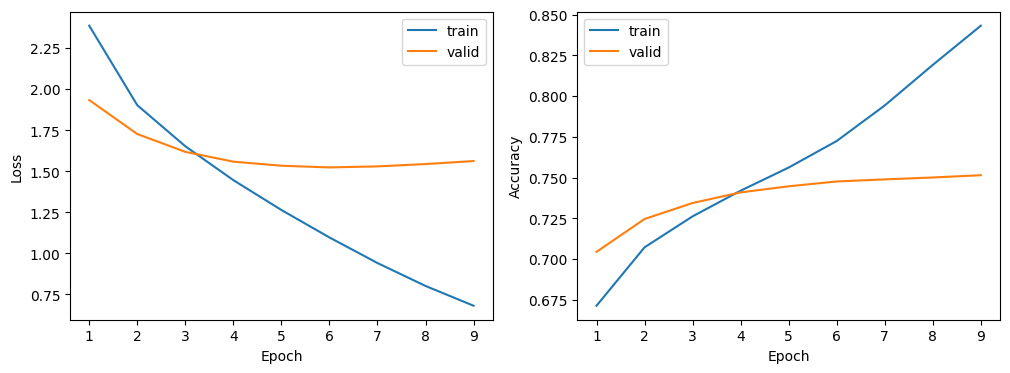

In [58]:
for n_units in n_units_list:
    hist = models[f'n_units_{n_units}']['hist']
    print(f"Resultados del modelo con {n_units} unidades:")
    # Entrenamiento
    epoch_count = range(1, len(hist.history['accuracy']) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
    sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Se selecciona el modelo con mejores métricas.

In [59]:
best_model = models['n_units_128']

### 5 - Inferencia

In [60]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [61]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [62]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [63]:
def translate_sentence_sampling(input_seq, temperature=1.0, max_repeat=3):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []
    last_idx = None
    repeat_count = 0
    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        logits = output_tokens[0, 0, :] / temperature
        exp_logits = np.exp(logits - np.max(logits))  # estabilidad numérica
        probs = exp_logits / np.sum(exp_logits)
        idx = np.random.choice(len(probs), p=probs)
        
        if eos == idx:
            break

        # Si se repite el mismo token muchas veces, forzar corte
        if idx == last_idx:
            repeat_count += 1
            if repeat_count >= max_repeat:
                break
        else:
            repeat_count = 0
        last_idx = idx

        
        # Si el token es <sos> o <pad>, ignorar y no agregar a la secuencia
        if idx > 0 and idx != word2idx_outputs.get('<sos>', -1):
            word = idx2word_target.get(idx, '')
            output_sentence.append(word)

        states_value = [h, c]
        target_seq[0, 0] = idx
    # Recortar la secuencia si no se encontró <eos>
    return ' '.join(output_sentence[:max_out_len])

In [ ]:
def translate_sentence_beam_search_stochastic(input_seq, beam_width=3, temperature=1.0):
    states_value = encoder_model.predict(input_seq)
    sequences = [(['<sos>'], 0.0, states_value)]  # (sequence, score, states)

    for _ in range(max_out_len):
        all_candidates = []
        for seq, score, states in sequences:
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = word2idx_outputs.get(seq[-1], 0)

            output_tokens, h, c = decoder_model.predict([target_seq] + states)
            logits = output_tokens[0, 0, :] / temperature
            exp_logits = np.exp(logits - np.max(logits))  # estabilidad numérica
            probs = exp_logits / np.sum(exp_logits)

            # Obtener las top beam_width predicciones
            top_indices = np.argsort(probs)[-beam_width:]

            for idx in top_indices:
                word = idx2word_target.get(idx, '')
                candidate = (seq + [word], score - np.log(probs[idx]), [h, c])
                all_candidates.append(candidate)

        # Ordenar todas las secuencias candidatas por score y quedarse con las mejores beam_width
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

    # Seleccionar la secuencia con el mejor score que no termine en <eos>
    best_sequence = sequences[0][0]
    if '<eos>' in best_sequence:
        best_sequence = best_sequence[:best_sequence.index('<eos>')]

    return ' '.join(best_sequence[1:])

In [65]:
#decoder_embedding = decoder_model.get_layer('embedding_3')
#print(decoder_embedding.input_dim)   # debería dar 8000
#print(max(idx2word_target.keys()))  # revisar si hay indices mayores


In [66]:
#filtered = {w:i for w,i in word2idx_outputs.items() if i < decoder_embedding.input_dim}
#word2idx_outputs = filtered
#idx2word_target = {i:w for w,i in filtered.items()}


In [86]:
i = np.random.choice(len(input_sentences))
#encoder_input_sequences = best_model['encoder_input_sequences']
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 [==============================] - 0s 21ms/step
-
Input: You don't have a fever.
Response: no tienes nada de verdad


In [68]:
# Ejemplo de uso con muestreo aleatorio
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
#translation = translate_sentence_sampling(input_seq, temperature=0.2)
translation = translate_sentence_beam_search_stochastic(input_seq, temperature=0.2)
print('-')
print('Input:', input_sentences[i])
print('Response (sampling):', translation)

1/1 [==============================] - 0s 22ms/step
-
Input: She seemed to be suffering a heart attack.
Response (sampling): ella le aconsejó que hablara acerca de la fiesta


In [69]:
def generate_translations(input_test="", temperature=1.0):
    if input_test == "":
        # Seleccionar una oración al azar del dataset
        i = np.random.choice(len(input_sentences))
        encoder_sequence_test = encoder_input_sequences[i:i+1]
        print('Input:', input_sentences[i])
    else:
        # Procesar la oración de entrada
        integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
        print("Representacion en vector de tokens de ids", integer_seq_test)
        encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
        print("Padding del vector:", encoder_sequence_test)

        print('Input:', input_test)

    translation = translate_sentence(encoder_sequence_test)
    translation_2 = translate_sentence_beam_search_stochastic(encoder_sequence_test, temperature=temperature)
    
    print('Response:', translation)
    print('Response (Beam Search):', translation_2)


In [ ]:
input_test = "My mother say hi."
generate_translations(input_test=input_test, temperature=0.1)

Representacion en vector de tokens de ids [16, 212, 139, 6769]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0   16  212
   139 6769]]
Input: My mother say hi.
1/1 [==============================] - 0s 23ms/step
Response: mi padre me ha perdido
Response (Beam Search): a mary le gusta mi padre


In [71]:
input_test = "Every end is a new beginning"
generate_translations(input_test=input_test, temperature=0.1)

Representacion en vector de tokens de ids [152, 537, 7, 6, 155, 1006]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0  152  537    7    6
   155 1006]]
Input: Every end is a new beginning
1/1 [==============================] - 0s 25ms/step
Response: todos todos los días se ponen buenos amigos
Response (Beam Search): todo el mundo es un amigo más grande


In [78]:
input_test = "The best of both worlds"
generate_translations(input_test=input_test, temperature=0.1)

Representacion en vector de tokens de ids [1, 252, 10, 508]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   1 252  10 508]]
Input: The best of both worlds
1/1 [==============================] - 0s 22ms/step
Response: tom se puso a mary
Response (Beam Search): tom se quitó el lunes


In [73]:
input_test = "I know what you mean"
generate_translations(input_test=input_test, temperature=0.1)

Representacion en vector de tokens de ids [2, 37, 24, 4, 428]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   2  37  24   4 428]]
Input: I know what you mean
1/1 [==============================] - 0s 22ms/step
Response: sé que no estabas aquí
Response (Beam Search): sé lo que estás bromeando


In [74]:
input_test = "Give me a break"
generate_translations(input_test=input_test, temperature=0.1)

Representacion en vector de tokens de ids [123, 17, 6, 793]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0 123  17   6 793]]
Input: Give me a break
1/1 [==============================] - 0s 23ms/step
Response: dame un poco de nuevo
Response (Beam Search): dame un libro


In [75]:
input_test = "where there is a will there is a way"
generate_translations(input_test=input_test, temperature=0.1)

Representacion en vector de tokens de ids [100, 46, 7, 6, 41, 46, 7, 6, 159]
Padding del vector: [[  0   0   0   0   0   0   0 100  46   7   6  41  46   7   6 159]]
Input: where there is a will there is a way
1/1 [==============================] - 0s 22ms/step
Response: cuando es el único que utiliza en el campo
Response (Beam Search): a qué hora es una buena idea


### 6 - Conclusión
A primera vista parece que el modelo tendría que funcionar muy bien por el accuracy alcanzado. La realidad es que las respuestas no tienen que ver demasiado con la pregunta/traducción pero la respuesta en si tiene bastante coherencia.\
Para poder mejorar el modelo haría falta poder consumir todo el dataset y todo el vocabulario, pero la cantidad de RAM no es suficiente.\
Este problema se resuelve con:
- Utilizando un DataGenerator para no levantar todo el dataset junto en el entrenamiento.
- Transfer learning evitando tener que entrenar todo el modelo  

1